In [1]:
import os

In [2]:
os.chdir('/Users/maruyamakouta/')

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from collections import  Counter
plt.style.use('ggplot')
stop=set(stopwords.words('english'))
import re
from nltk.tokenize import word_tokenize
import string
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from tensorflow.python.keras.initializers import Constant
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.optimizers import Adam

In [4]:
#今回は２００９年５月から２０２０年６月５日までのトランプ大統領のツイート４３１２７件を取得しました。
#pythonのtwintというライブラリーを使うと、ユーザーID、取得の期間など指定しながら簡単に取得できます。


df= pd.read_csv('/Users/trumpalltweet.csv')

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (9,21) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
stop=set(stopwords.words('english'))

In [6]:
#この辺りからデータの内容を見ています。

df.head()

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,...,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
0,1268564690143232001,1268564689069527042,1591284365000,2020-06-05,00:26:05,JST,25073877,realdonaldtrump,Donald J. Trump,NaN,...,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '25073877', 'username': 'realDona...",NaN,NaN,NaN,NaN
1,1268564689069527042,1268564689069527042,1591284365000,2020-06-05,00:26:05,JST,25073877,realdonaldtrump,Donald J. Trump,NaN,...,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '25073877', 'username': 'realDona...",NaN,NaN,NaN,NaN
2,1268552570617901058,1268552570617901058,1591281476000,2020-06-04,23:37:56,JST,25073877,realdonaldtrump,Donald J. Trump,NaN,...,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '25073877', 'username': 'realDona...",NaN,NaN,NaN,NaN
3,1268522581944082433,1268522581944082433,1591274326000,2020-06-04,21:38:46,JST,25073877,realdonaldtrump,Donald J. Trump,NaN,...,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '25073877', 'username': 'realDona...",NaN,NaN,NaN,NaN
4,1268497685553823745,1268497685553823745,1591268390000,2020-06-04,19:59:50,JST,25073877,realdonaldtrump,Donald J. Trump,NaN,...,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '25073877', 'username': 'realDona...",NaN,NaN,NaN,NaN


In [7]:
df[['tweet']].head()

,tweet
0,....I will never stop working to secure the re...
1,"I am to happy announce that Navy Veteran, Mich..."
2,Please let this serve as my Complete and Total...
3,Disgraceful! https://twitter.com/donaldjtrumpj...
4,MAKE AMERICA GREAT AGAIN!


In [8]:
df=df['tweet']

In [9]:
#ここからはデータクレンジングという作業です。分析しやすいように余計な言葉を取り除いていきます
df.head()

0    ....I will never stop working to secure the re...
1    I am to happy announce that Navy Veteran, Mich...
2    Please let this serve as my Complete and Total...
3    Disgraceful! https://twitter.com/donaldjtrumpj...
4                            MAKE AMERICA GREAT AGAIN!
Name: tweet, dtype: object

In [10]:
example="New competition launched :https://www.kaggle.com/c/nlp-getting-started"

In [12]:
#urlを除きます

def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)
remove_URL(example)

'New competition launched :'

In [13]:
df=df.apply(lambda x : remove_URL(x))

In [14]:
example = """<div>
<h1>Real or Fake</h1>
<p>Kaggle </p>
<a href="https://www.kaggle.com/c/nlp-getting-started">getting started</a>
</div>"""

In [15]:
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)
print(remove_html(example))


Real or Fake
Kaggle 
getting started



In [16]:
df=df.apply(lambda x : remove_html(x))

In [18]:
#！や？を除きます
    
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

example="I am a #king"
print(remove_punct(example))

I am a king


In [19]:
df=df.apply(lambda x : remove_punct(x))

In [20]:
df.head()

0    I will never stop working to secure the releas...
1    I am to happy announce that Navy Veteran Micha...
2    Please let this serve as my Complete and Total...
3                                       Disgraceful  …
4                             MAKE AMERICA GREAT AGAIN
Name: tweet, dtype: object

In [21]:

df.shape

(43127,)

In [23]:
#大文字を全て小文字にします
df = df.str.lower()

In [24]:
df.head()

0    i will never stop working to secure the releas...
1    i am to happy announce that navy veteran micha...
2    please let this serve as my complete and total...
3                                       disgraceful  …
4                             make america great again
Name: tweet, dtype: object

In [25]:
#さらにthe,don'tなどを除きます
    
stop_words = stopwords.words('english')
stop_words.append('realdonaldtrump')
stop_words.append('trump')
stop =stop_words

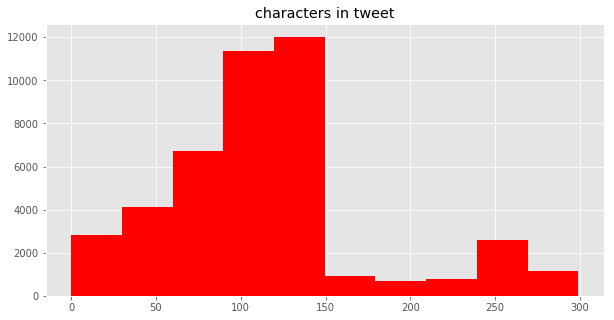

In [26]:
#１ツイートに含まれる文字数をグラフにしました。

fig,(ax1)=plt.subplots(1,figsize=(10,5))
tweet_len=df.str.len()
ax1.hist(tweet_len,color='red')
ax1.set_title('characters in tweet')
plt.show()

Text(0.5, 1.0, ' words in  tweets')

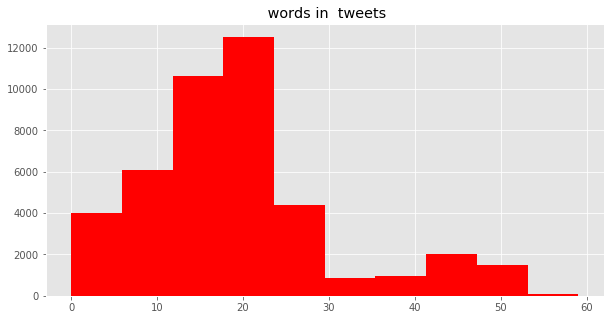

In [27]:
#１ツイートに含まれる単語数です。一番多いのは２０単語前後でしょうか。

fig,(ax1)=plt.subplots(1,figsize=(10,5))
tweet_len=df.str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='red')
ax1.set_title(' words in  tweets')

In [28]:
def create_corpus(df):
    corpus=[]
    
    for x in df.str.split():
        for i in x:
            corpus.append(i)
    return corpus

In [29]:
corpus=create_corpus(df)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

In [30]:
corpus=create_corpus(df)

In [31]:
corpus

['i',
 'will',
 'never',
 'stop',
 'working',
 'to',
 'secure',
 'the',
 'release',
 'of',
 'all',
 'americans',
 'held',
 'hostage',
 'overseas',
 'thank',
 'you',
 'switzerland',
 'for',
 'your',
 'great',
 'assistance',
 'i',
 'am',
 'to',
 'happy',
 'announce',
 'that',
 'navy',
 'veteran',
 'michael',
 'white',
 'who',
 'has',
 'been',
 'detained',
 'by',
 'iran',
 'for',
 '683',
 'days',
 'is',
 'on',
 'a',
 'swiss',
 'plane',
 'that',
 'just',
 'left',
 'iranian',
 'airspace',
 'we',
 'expect',
 'him',
 'to',
 'be',
 'home',
 'with',
 'his',
 'family',
 'in',
 'america',
 'very',
 'soon',
 'please',
 'let',
 'this',
 'serve',
 'as',
 'my',
 'complete',
 'and',
 'total',
 'endorsement',
 'of',
 'a',
 'great',
 'fighter',
 'and',
 'ally',
 'in',
 'north',
 'carolina',
 'lyndabennettnc',
 'she',
 'is',
 'strong',
 'on',
 'crime',
 'borders',
 'military',
 'our',
 'great',
 'vets',
 '2a',
 'she',
 'will',
 'be',
 'a',
 'great',
 'help',
 'to',
 'me',
 'in',
 'dc',
 'early',
 'voting

In [37]:
counter=Counter(corpus)
most=counter.most_common()
X=[]
Y=[]
for word,count in most[:70]:
    if (word not in stop) :
        X.append(word)
        Y.append(count)

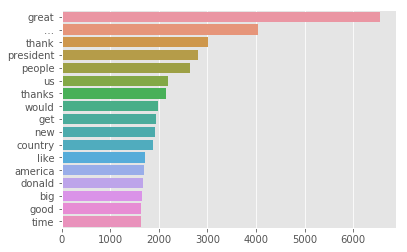

In [38]:
sns.barplot(y=X,x=Y)

In [ ]:
#上のグラフが結果です。１位はダントツでgreat。ほぼ６回に一回はつぶやいている計算です。
#２番目が表示できていませんが、それ以下は、優しい単語が並びます。